In [1]:
# only if needed
#!python -m spacy download en_core_web_sm

In [2]:
import spacy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
%matplotlib inline

# %matplotlib widget
nlp = spacy.load("en_core_web_sm")

In [3]:
emails_df = pd.read_csv('data/cleaned_emails.csv', usecols=['email_text'])
emails_df

,email_text
0,Here is our forecast
1,"Jeff,\n\nIn light of the puny VAR allotments a..."
2,Greg here are my questions regarding the cedar...
3,Is AMF willing to put up the additional earnes...
4,please send me their resumes
...,...
33528,Sundance 3:\tAug. 16 to Sept. 13\nSundance 4:\...
33529,The canadian sap # is \tp00565421\nthe us sap ...
33530,yes
33531,One of us will attend


In [4]:
emails = emails_df['email_text']
emails[:5]

0                                 Here is our forecast
1    Jeff,\n\nIn light of the puny VAR allotments a...
2    Greg here are my questions regarding the cedar...
3    Is AMF willing to put up the additional earnes...
4                         please send me their resumes
Name: email_text, dtype: object

In [5]:
def preprocess(email):
    return email.lower()

In [6]:
email = random.choice(emails)
print(f"Raw:\n{email}")
print()
print(f"Processed:\n{preprocess(email)}")

Raw:
Thanks

Processed:
thanks


In [7]:
emails_processed = []
for email in emails:
    emails_processed.append(preprocess(email))

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

tf_idf_vec = TfidfVectorizer(stop_words='english', max_features=10000)
tf_idf_raw = tf_idf_vec.fit_transform(emails_processed)
# tf_idf_normalized = normalize(tf_idf_raw)
# tf_idf = tf_idf_normalized.toarray()
tf_idf = tf_idf_raw.toarray()

In [9]:
pd.DataFrame(tf_idf, columns=tf_idf_vec.get_feature_names()).columns

Index(['00', '000', '0029', '005', '008', '00am', '00p', '00pm', '01', '0102',
       ...
       'zhiyun', 'zimin', 'zip', 'zipper', 'zivic', 'zone', 'zonecode',
       'zones', 'zoo', 'zufferli'],
      dtype='object', length=10000)

## 2 Dimensional

In [10]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2) # fit to 2 dim
tf_idf_2dim = pca_2d.fit_transform(tf_idf) # apply fit

In [11]:
from sklearn.cluster import KMeans

### Elbow Method

In [12]:
kmeans_list = [KMeans(n_clusters=n, max_iter=1000, algorithm='auto') for n in range(1,10)]
kmeans_list

[KMeans(max_iter=1000, n_clusters=1),
 KMeans(max_iter=1000, n_clusters=2),
 KMeans(max_iter=1000, n_clusters=3),
 KMeans(max_iter=1000, n_clusters=4),
 KMeans(max_iter=1000, n_clusters=5),
 KMeans(max_iter=1000, n_clusters=6),
 KMeans(max_iter=1000, n_clusters=7),
 KMeans(max_iter=1000),
 KMeans(max_iter=1000, n_clusters=9)]

In [13]:
scores = [kmeans.fit(tf_idf_2dim).score(tf_idf_2dim) for kmeans in kmeans_list]
scores

[-1089.7298684766743,
 -528.8890856702386,
 -255.3656344075853,
 -129.55327044485932,
 -91.2500136884121,
 -63.45423756885242,
 -44.71347813401786,
 -34.035245116600144,
 -25.54771195627104]

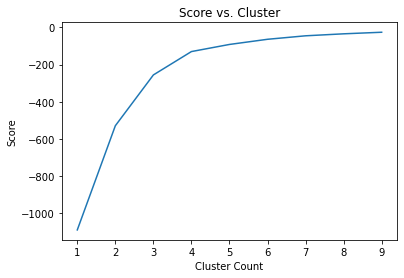

In [14]:
plt.plot(range(1,10), scores)
plt.xlabel('Cluster Count')
plt.ylabel('Score')
plt.title("Score vs. Cluster")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4, max_iter=1000, algorithm='auto')
fit_result = kmeans.fit(tf_idf_2dim)

preds = kmeans.predict(tf_idf_2dim)

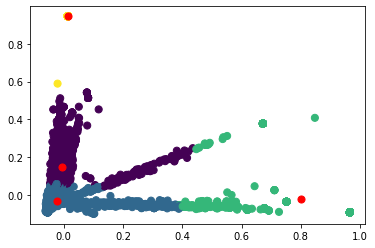

In [16]:
plt.scatter(tf_idf_2dim[:, 0], tf_idf_2dim[:, 1], c=preds, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='red', s=50)

### Cluster centers

In [17]:
kmeans.cluster_centers_

array([[-0.00701844,  0.14873101],
       [-0.02342729, -0.03342052],
       [ 0.80198619, -0.02149791],
       [ 0.01391004,  0.94470001]])

In [18]:
def distance(p1, p2):
    if len(p1) != len(p2):
        raise ValueError("Invalid dimensions: dimensions do not match") # invalid dimensions
    return np.sqrt(np.sum((p1-p2)**2, axis=0))

In [19]:
def find_closest_points(centers, points):
    representatives = []
    for center in centers:
        closest = []
        best_dist = 999
        for point in points:
            dist = distance(center, point)
            if dist < best_dist:
                best_dist = dist
                closest = point
        representatives.append(closest)
    return representatives

In [20]:
represent_2d = find_closest_points(kmeans.cluster_centers_, tf_idf_2dim)
represent_2d

[array([-0.00489835,  0.14919406]),
 array([-0.0233715 , -0.03338406]),
 array([ 0.7515622 , -0.03702293]),
 array([0.01402496, 0.94588956])]

Converting back to original space

In [21]:
represent_2d_original_space = pca_2d.inverse_transform(represent_2d)
represent_2d_original_space

array([[ 4.78677614e-03,  2.16470362e-03,  5.24436679e-05, ...,
         2.57613574e-05,  3.26467604e-05,  1.30865065e-04],
       [ 6.02506960e-03,  3.30594837e-03,  8.84135361e-05, ...,
         3.50822315e-05,  6.84188163e-05,  2.04686260e-04],
       [ 1.66652861e-04,  9.24686291e-05,  2.93277599e-05, ...,
        -5.87705485e-06, -1.15205820e-05, -2.33428065e-06],
       [-1.48544527e-04, -2.55773125e-03, -9.97558628e-05, ...,
        -1.16374369e-05, -1.17030722e-04, -1.74671771e-04]])

## 3 Dimensional

In [22]:
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=4) # fit to 3 dim
tf_idf_3dim = pca_3d.fit_transform(tf_idf) # apply fit

### Elbow Method

In [23]:
kmeans_list_3d = [KMeans(n_clusters=n, max_iter=1000, algorithm='auto') for n in range(1,10)]
kmeans_list_3d

[KMeans(max_iter=1000, n_clusters=1),
 KMeans(max_iter=1000, n_clusters=2),
 KMeans(max_iter=1000, n_clusters=3),
 KMeans(max_iter=1000, n_clusters=4),
 KMeans(max_iter=1000, n_clusters=5),
 KMeans(max_iter=1000, n_clusters=6),
 KMeans(max_iter=1000, n_clusters=7),
 KMeans(max_iter=1000),
 KMeans(max_iter=1000, n_clusters=9)]

In [24]:
scores_3d = [kmeans.fit(tf_idf_3dim).score(tf_idf_3dim) for kmeans in kmeans_list]
scores_3d

[-1565.3843342303398,
 -1004.4787381188605,
 -730.3972814353835,
 -522.4260803869571,
 -373.94490823805114,
 -252.25898920206635,
 -214.81723934251877,
 -182.22974480760095,
 -155.32038723934124]

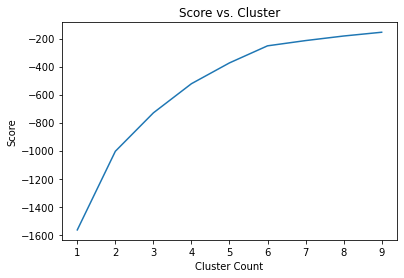

In [25]:
plt.plot(range(1,10), scores_3d)
plt.xlabel('Cluster Count')
plt.ylabel('Score')
plt.title("Score vs. Cluster")
plt.show()

In [26]:
kmeans_3d = KMeans(n_clusters=4, max_iter=1000, algorithm='auto')
fit_result = kmeans_3d.fit(tf_idf_3dim)

preds = kmeans_3d.predict(tf_idf_3dim)

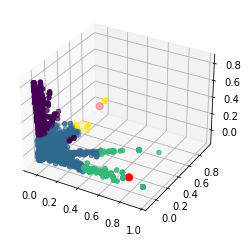

In [27]:
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points

ax.scatter3D(tf_idf_3dim[:, 0], tf_idf_3dim[:, 1], tf_idf_3dim[:, 2], c=preds, cmap='viridis');
ax.scatter3D(kmeans_3d.cluster_centers_[:,0],kmeans_3d.cluster_centers_[:,1],kmeans_3d.cluster_centers_[:,2], c='red', s=50)

### Cluster centers

In [28]:
kmeans_3d.cluster_centers_

array([[-3.72454735e-02, -4.94439452e-02,  4.48903969e-01,
         9.54050557e-03],
       [-2.08778813e-02, -8.11716645e-03, -1.48498228e-02,
        -3.48342703e-04],
       [ 7.97368968e-01, -1.93339800e-02,  8.49644456e-03,
        -1.50153507e-03],
       [ 1.45589736e-02,  8.45478185e-01,  3.73086930e-02,
         7.32728168e-03]])

In [29]:
represent_3d = find_closest_points(kmeans_3d.cluster_centers_, tf_idf_3dim)
represent_3d

[array([-0.03696269, -0.06237587,  0.44431943,  0.02012135]),
 array([-0.0223643 , -0.0072532 , -0.01567282,  0.00263581]),
 array([ 0.75156347, -0.03702192, -0.00373762, -0.01656486]),
 array([0.01402511, 0.94588797, 0.04695728, 0.01123191])]

In [30]:
represent_3d_original_space = pca_3d.inverse_transform(represent_3d)
represent_3d_original_space

array([[ 1.61373630e-03,  2.41326572e-03,  1.08157222e-04, ...,
         5.20166656e-06, -2.76203166e-05,  1.55296959e-04],
       [ 5.99735280e-03,  3.17682841e-03,  8.24059091e-05, ...,
         3.47245013e-05,  6.83910532e-05,  1.96455148e-04],
       [ 3.44891151e-04,  1.60983513e-04,  3.17640966e-05, ...,
        -4.44839731e-06, -1.69989232e-05, -1.96107399e-08],
       [-7.22782544e-04, -2.70875933e-03, -9.97735744e-05, ...,
        -1.56563040e-05, -1.24385838e-04, -1.82431591e-04]])